In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # add parent directory to path
from src.utils import load_cleaned_data, metrics, split
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, XLMRobertaConfig
from torch.optim import AdamW
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

2025-04-03 11:59:35.056250: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-03 11:59:35.478710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743674375.660832   78055 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743674375.688939   78055 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743674376.055798   78055 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Now let's load and explore the data:

In [3]:
# Load data from your existing code
data = load_cleaned_data("../data/preprocessed/byarticle_clean.tsv")
X = data['full_text']
y = data['label']

print(f"Total samples: {len(data)}")
print(f"Label distribution: {y.value_counts().to_dict()}")

print("\nSample article (non-hyperpartisan):")
print(X[y == 0].iloc[0][:200] + "...")
print("\nSample article (hyperpartisan):")
print(X[y == 1].iloc[0][:200] + "...")

Total samples: 645
Label distribution: {0: 407, 1: 238}

Sample article (non-hyperpartisan):
It's 1968 All Over Again. Almost a half-century ago, in 1968, the United States seemed to be falling apart. The Vietnam War, a bitter and close presidential election, antiwar protests, racial riots, p...

Sample article (hyperpartisan):
Kucinich: Reclaiming the money power. Money ( Image by 401(K) 2013 ) Permission Details DMCA No Pill Can Stop Tinnitus, But This 1 Weird Trick Can The walls are closing in on Congress. Terrifying wall...


## Let's set up the tokenizer and create a custom dataset class:

In [4]:
model_name = "xlm-roberta-base"  # or "xlm-roberta-large" for better performance
tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)
config = XLMRobertaConfig.from_pretrained(model_name)
#config.hidden_dropout_prob = 0.3
#config.attention_probs_dropout_prob = 0.3
config.classifier_dropout = 0.3
config.num_labels = 2


class HyperpartisanDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = int(self.labels.iloc[idx])
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }
# Test the dataset class with a small sample
test_dataset = HyperpartisanDataset(X.iloc[:5], y.iloc[:5], tokenizer)
sample_item = test_dataset[0]
print(f"Input shape: {sample_item['input_ids'].shape}")
print(f"Attention mask shape: {sample_item['attention_mask'].shape}")
print(f"Label: {sample_item['labels']}")

Input shape: torch.Size([512])
Attention mask shape: torch.Size([512])
Label: 1


## Now, let's define our training and evaluation functions:

In [5]:
# Set up device
device = None
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    print("No GPU available, using CPU.")
print(f"Using device: {device}")

def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    
    progress_bar = tqdm(data_loader, desc="Training")
    for batch in progress_bar:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})
        
    return total_loss / len(data_loader)

def evaluate(model, data_loader, device):
    model.eval()
    
    predictions = []
    true_labels = []
    total_loss = 0
    
    progress_bar = tqdm(data_loader, desc="Evaluating")
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_loss += loss.item()
            
            _, preds = torch.max(outputs.logits, dim=1)
            
            predictions.extend(preds.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())
            
            progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})
    
    avg_loss = total_loss / len(data_loader)
    balanced_accuracy = balanced_accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='binary', zero_division=0)
    recall = recall_score(true_labels, predictions, average='binary', zero_division=0)
    f1 = f1_score(true_labels, predictions, average='binary', zero_division=0)

    unique_true, counts_true = np.unique(true_labels, return_counts=True)
    unique_pred, counts_pred = np.unique(predictions, return_counts=True)

    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Accuracy: {balanced_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"True labels distribution: {dict(zip(unique_true, counts_true))}")
    print(f"Predicted labels distribution: {dict(zip(unique_pred, counts_pred))}")
    
    return {
        'true_labels': true_labels,
        'predictions': predictions,
        'loss': avg_loss,
        'balanced_accuracy': balanced_accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def early_stopping(val_history, patience=3, delta=0.001):
    """
    Check if training should stop based on validation metric history
    
    Parameters:
    - val_history: List of validation performance metrics (e.g., accuracy)
    - patience: How many epochs to wait for improvement
    - delta: Minimum change to qualify as improvement
    
    Returns:
    - stop_training: Boolean indicating whether to stop training
    - best_epoch: Index of the best epoch
    """
    if len(val_history) <= patience:
        return False, None
    
    best_value = max(val_history)
    best_epoch = val_history.index(best_value)
    
    for i in range(len(val_history) - patience, len(val_history)):
        if i > best_epoch and val_history[i] > best_value - delta:
            return False, best_epoch
    
    return True, best_epoch

Using device: cuda


## Let's implement cross-validation:

In [6]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)

BATCH_SIZE = 8
EPOCHS = 8
LEARNING_RATE = 2e-5
PATIENCE = 3

fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n=== Fold {fold+1}/{n_splits} ===")
    
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    print(f"Training samples: {len(X_train_fold)}")
    print(f"Validation samples: {len(X_val_fold)}")
    
    train_dataset = HyperpartisanDataset(X_train_fold, y_train_fold, tokenizer)
    val_dataset = HyperpartisanDataset(X_val_fold, y_val_fold, tokenizer)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    
    model = XLMRobertaForSequenceClassification.from_pretrained(
        model_name,
        config=config,
    ).to(device)
    
    
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    val_accuracies = []
    best_model_state = None
    best_epoch = 0
    
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        
        train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
        print(f"Training loss: {train_loss:.4f}")
        
        print("Validation results:")
        val_results = evaluate(model, val_loader, device)
        val_accuracies.append(val_results['balanced_accuracy'])

        if val_results['balanced_accuracy'] == max(val_accuracies):
            best_model_state = model.state_dict().copy()
            best_epoch = epoch
    
        # Check for early stopping
        stop_training, _ = early_stopping(val_accuracies, patience=PATIENCE)
        if stop_training:
            print(f"Early stopping triggered! No improvement for 3 epochs. Best epoch was {best_epoch+1}")
            break
    
    fold_results.append(val_results)
    
    model.save_pretrained(f"../models/xlm_roberta_fold_{fold+1}")
    
    del model
    torch.cuda.empty_cache()


=== Fold 1/5 ===
Training samples: 516
Validation samples: 129


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.6417
Validation results:


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Loss: 0.5307
Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
True labels distribution: {np.int64(0): np.int64(81), np.int64(1): np.int64(48)}
Predicted labels distribution: {np.int64(0): np.int64(129)}

Epoch 2/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.5552
Validation results:


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Loss: 0.4792
Accuracy: 0.7280
Precision: 0.7073
Recall: 0.6042
F1 Score: 0.6517
True labels distribution: {np.int64(0): np.int64(81), np.int64(1): np.int64(48)}
Predicted labels distribution: {np.int64(0): np.int64(88), np.int64(1): np.int64(41)}

Epoch 3/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.5153
Validation results:


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Loss: 0.6782
Accuracy: 0.6713
Precision: 0.7692
Recall: 0.4167
F1 Score: 0.5405
True labels distribution: {np.int64(0): np.int64(81), np.int64(1): np.int64(48)}
Predicted labels distribution: {np.int64(0): np.int64(103), np.int64(1): np.int64(26)}

Epoch 4/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.4341
Validation results:


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Loss: 0.5698
Accuracy: 0.7720
Precision: 0.7000
Recall: 0.7292
F1 Score: 0.7143
True labels distribution: {np.int64(0): np.int64(81), np.int64(1): np.int64(48)}
Predicted labels distribution: {np.int64(0): np.int64(79), np.int64(1): np.int64(50)}
Early stopping triggered! No improvement for 3 epochs. Best epoch was 4


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Fold 2/5 ===
Training samples: 516
Validation samples: 129

Epoch 1/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.6392
Validation results:


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Loss: 0.5787
Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
True labels distribution: {np.int64(0): np.int64(83), np.int64(1): np.int64(46)}
Predicted labels distribution: {np.int64(0): np.int64(129)}

Epoch 2/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.5289
Validation results:


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Loss: 0.4721
Accuracy: 0.8106
Precision: 0.6909
Recall: 0.8261
F1 Score: 0.7525
True labels distribution: {np.int64(0): np.int64(83), np.int64(1): np.int64(46)}
Predicted labels distribution: {np.int64(0): np.int64(74), np.int64(1): np.int64(55)}

Epoch 3/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.3941
Validation results:


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Loss: 0.4065
Accuracy: 0.8153
Precision: 0.7907
Recall: 0.7391
F1 Score: 0.7640
True labels distribution: {np.int64(0): np.int64(83), np.int64(1): np.int64(46)}
Predicted labels distribution: {np.int64(0): np.int64(86), np.int64(1): np.int64(43)}

Epoch 4/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.3192
Validation results:


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Loss: 0.5627
Accuracy: 0.7851
Precision: 0.8529
Recall: 0.6304
F1 Score: 0.7250
True labels distribution: {np.int64(0): np.int64(83), np.int64(1): np.int64(46)}
Predicted labels distribution: {np.int64(0): np.int64(95), np.int64(1): np.int64(34)}
Early stopping triggered! No improvement for 3 epochs. Best epoch was 3


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Fold 3/5 ===
Training samples: 516
Validation samples: 129

Epoch 1/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.6194
Validation results:


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Loss: 0.7180
Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
True labels distribution: {np.int64(0): np.int64(77), np.int64(1): np.int64(52)}
Predicted labels distribution: {np.int64(0): np.int64(129)}

Epoch 2/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.5786
Validation results:


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Loss: 0.5086
Accuracy: 0.8041
Precision: 0.8750
Recall: 0.6731
F1 Score: 0.7609
True labels distribution: {np.int64(0): np.int64(77), np.int64(1): np.int64(52)}
Predicted labels distribution: {np.int64(0): np.int64(89), np.int64(1): np.int64(40)}

Epoch 3/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.5117
Validation results:


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Loss: 0.4688
Accuracy: 0.8264
Precision: 0.8636
Recall: 0.7308
F1 Score: 0.7917
True labels distribution: {np.int64(0): np.int64(77), np.int64(1): np.int64(52)}
Predicted labels distribution: {np.int64(0): np.int64(85), np.int64(1): np.int64(44)}

Epoch 4/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.4199
Validation results:


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Loss: 0.4856
Accuracy: 0.8166
Precision: 0.8125
Recall: 0.7500
F1 Score: 0.7800
True labels distribution: {np.int64(0): np.int64(77), np.int64(1): np.int64(52)}
Predicted labels distribution: {np.int64(0): np.int64(81), np.int64(1): np.int64(48)}
Early stopping triggered! No improvement for 3 epochs. Best epoch was 3


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Fold 4/5 ===
Training samples: 516
Validation samples: 129

Epoch 1/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.6928
Validation results:


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Loss: 0.5481
Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
True labels distribution: {np.int64(0): np.int64(85), np.int64(1): np.int64(44)}
Predicted labels distribution: {np.int64(0): np.int64(129)}

Epoch 2/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.6167
Validation results:


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Loss: 0.5087
Accuracy: 0.6074
Precision: 0.7857
Recall: 0.2500
F1 Score: 0.3793
True labels distribution: {np.int64(0): np.int64(85), np.int64(1): np.int64(44)}
Predicted labels distribution: {np.int64(0): np.int64(115), np.int64(1): np.int64(14)}

Epoch 3/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.4887
Validation results:


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Loss: 0.5050
Accuracy: 0.6524
Precision: 0.7619
Recall: 0.3636
F1 Score: 0.4923
True labels distribution: {np.int64(0): np.int64(85), np.int64(1): np.int64(44)}
Predicted labels distribution: {np.int64(0): np.int64(108), np.int64(1): np.int64(21)}

Epoch 4/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.3971
Validation results:


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Loss: 0.6159
Accuracy: 0.6924
Precision: 0.8261
Recall: 0.4318
F1 Score: 0.5672
True labels distribution: {np.int64(0): np.int64(85), np.int64(1): np.int64(44)}
Predicted labels distribution: {np.int64(0): np.int64(106), np.int64(1): np.int64(23)}
Early stopping triggered! No improvement for 3 epochs. Best epoch was 4


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Fold 5/5 ===
Training samples: 516
Validation samples: 129

Epoch 1/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.7181
Validation results:


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Loss: 0.6402
Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
True labels distribution: {np.int64(0): np.int64(81), np.int64(1): np.int64(48)}
Predicted labels distribution: {np.int64(0): np.int64(129)}

Epoch 2/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.6940
Validation results:


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Loss: 0.6917
Accuracy: 0.6570
Precision: 0.5000
Recall: 0.7708
F1 Score: 0.6066
True labels distribution: {np.int64(0): np.int64(81), np.int64(1): np.int64(48)}
Predicted labels distribution: {np.int64(0): np.int64(55), np.int64(1): np.int64(74)}

Epoch 3/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.6658
Validation results:


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Loss: 0.6768
Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
True labels distribution: {np.int64(0): np.int64(81), np.int64(1): np.int64(48)}
Predicted labels distribution: {np.int64(0): np.int64(129)}

Epoch 4/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.6324
Validation results:


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Loss: 0.5226
Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
True labels distribution: {np.int64(0): np.int64(81), np.int64(1): np.int64(48)}
Predicted labels distribution: {np.int64(0): np.int64(129)}
Early stopping triggered! No improvement for 3 epochs. Best epoch was 2


## Let's analyze the cross-validation results:


Cross-validation summary:
Balanced accuracy: 0.7132 ± 0.1142
Precision: 0.6383 ± 0.3234
Recall: 0.5083 ± 0.2780
F1 Score: 0.5573 ± 0.2874


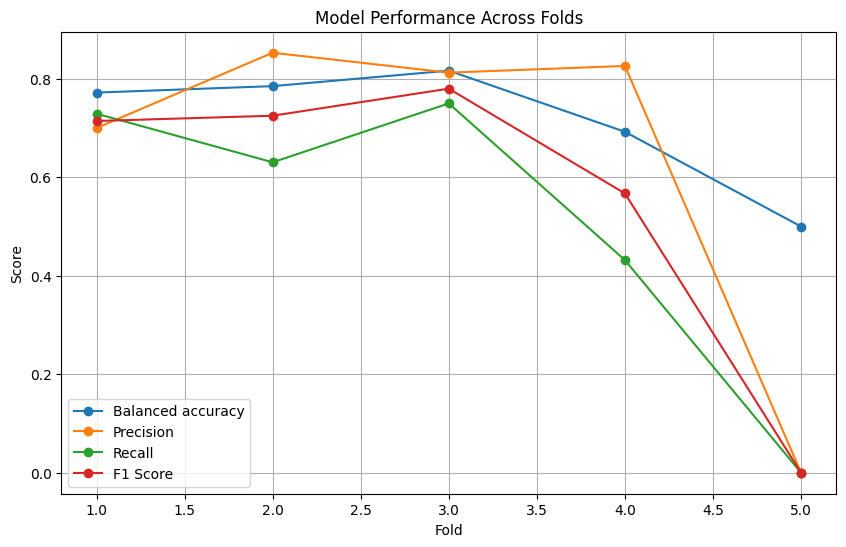

In [7]:
# Analyze cross-validation results
accuracies = [result['balanced_accuracy'] for result in fold_results]
precisions = [result['precision'] for result in fold_results]
recalls = [result['recall'] for result in fold_results]
f1_scores = [result['f1'] for result in fold_results]

print("\nCross-validation summary:")
print(f"Balanced accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

# Visualize metrics across folds
plt.figure(figsize=(10, 6))
fold_nums = list(range(1, n_splits + 1))
plt.plot(fold_nums, accuracies, 'o-', label='Balanced accuracy')
plt.plot(fold_nums, precisions, 'o-', label='Precision')
plt.plot(fold_nums, recalls, 'o-', label='Recall')
plt.plot(fold_nums, f1_scores, 'o-', label='F1 Score')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Model Performance Across Folds')
plt.legend()
plt.grid(True)
plt.show()

## Now let's train our final model on the original train/test split:

In [8]:
X_train, X_test, y_train, y_test = split(X, y)

train_dataset = HyperpartisanDataset(X_train, y_train, tokenizer)
test_dataset = HyperpartisanDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

final_model = XLMRobertaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
).to(device)

# Prepare optimizer and scheduler
optimizer = AdamW(final_model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Training loop
print("\nTraining final model...")
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    # Train
    train_loss = train_epoch(final_model, train_loader, optimizer, scheduler, device)
    print(f"Training loss: {train_loss:.4f}")

# Save the final model
final_model.save_pretrained("../models/xlm_roberta_final")
tokenizer.save_pretrained("../models/xlm_roberta_final")

# Evaluate on test set
print("\nTest set evaluation:")
test_results = evaluate(final_model, test_loader, device)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training final model...

Epoch 1/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.6865

Epoch 2/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.6383

Epoch 3/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.5831

Epoch 4/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.5977

Epoch 5/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.4522

Epoch 6/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.3500

Epoch 7/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.3036

Epoch 8/8


Training:   0%|          | 0/65 [00:00<?, ?it/s]

Training loss: 0.2139

Test set evaluation:


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Loss: 0.5926
Accuracy: 0.7716
Precision: 0.7619
Recall: 0.6667
F1 Score: 0.7111
True labels distribution: {np.int64(0): np.int64(81), np.int64(1): np.int64(48)}
Predicted labels distribution: {np.int64(0): np.int64(87), np.int64(1): np.int64(42)}


## Let's look at the most challenging examples - the ones where our model made mistakes:

In [9]:
# Analyze errors
test_true_labels = test_results['true_labels']
test_predictions = test_results['predictions']

errors = [(i, pred, true) for i, (pred, true) in 
          enumerate(zip(test_predictions, test_true_labels)) if pred != true]

print(f"\nTotal errors: {len(errors)} out of {len(test_predictions)} samples ({len(errors)/len(test_predictions)*100:.2f}%)")

# Examine a few errors
for i, (idx, pred, true) in enumerate(errors[:5]):
    actual_idx = X_test.index[idx]  # Get the original index in the dataset
    text = X_test.iloc[idx][:500] + "..."  # Show first 500 chars
    
    print(f"\nError {i+1}:")
    print(f"Predicted: {'hyperpartisan' if pred == 1 else 'not hyperpartisan'}")
    print(f"Actual: {'hyperpartisan' if true == 1 else 'not hyperpartisan'}")
    print(f"Text snippet: {text}")


Total errors: 26 out of 129 samples (20.16%)

Error 1:
Predicted: not hyperpartisan
Actual: hyperpartisan
Text snippet: Juanita Broaddrick: Trump Apologized; Where's Bill and Hillary's Apologies? Prior to Sunday's presidential debate, four women who have accused the Clintons of wrongdoing, including allegations of sexual deviancy, spoke at a press availability with Republican Donald Trump. Observers said Trump meant to contrast his vulgar leaked 2005 audiotape with the allegations from the women about their mistreatment at the hands of the Clintons. "It's so important...when people are talking about... the words ...

Error 2:
Predicted: hyperpartisan
Actual: not hyperpartisan
Text snippet: Do Not Resist (NR). Do Not Resist is an order to the viewer: Watch. Videos in newsfeeds depicting the murder of black men by police open automatically without warning on our screens all the time, forcing another wave of trauma for some black folks and other people of color. This film changes the per

## Finally, let's implement a simple prediction function for new articles:

In [10]:
def predict_hyperpartisan(text, model, tokenizer, device, max_length=512):
    model.eval()
    
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, prediction = torch.max(outputs.logits, dim=1)
    
    result = prediction.item()
    confidence = torch.softmax(outputs.logits, dim=1)[0][result].item()
    
    return {
        'prediction': 'hyperpartisan' if result == 1 else 'not hyperpartisan',
        'confidence': confidence,
        'label': result
    }

# Test with a couple of examples
sample_texts = [
    X_test.iloc[0],  # Test with a real example
    "This article proves that the President is the worst in history and a complete disaster for America.",  # Likely hyperpartisan
    "The Senate voted yesterday on the new healthcare bill, with 45 votes for and 55 against."  # Likely not hyperpartisan
]

for i, text in enumerate(sample_texts):
    result = predict_hyperpartisan(text, final_model, tokenizer, device)
    print(f"\nSample {i+1}:")
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.4f}")


Sample 1:
Prediction: hyperpartisan
Confidence: 0.9888

Sample 2:
Prediction: hyperpartisan
Confidence: 0.7443

Sample 3:
Prediction: not hyperpartisan
Confidence: 0.9397
